## Imports

In [56]:
from transformer import TransformerClassifier
from dataloader import *
import torch
import ot
from copy import deepcopy
from tqdm import tqdm
import optuna
from torchmetrics.classification import F1Score
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load the Data

In [3]:
#init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
data = pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')
# convert string label to binary (int) label (spam:1, non-spam:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == "positive"))

# train, test, val split
train, valid, test = loader.make_dataset(data)
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=512,
                                                     device=device)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start
Length of data after first step of preprocessing:  35832
Tokenizing the data...


c:\Users\atace\OneDrive\Desktop\ETH\9.Semester\Deep Learning\project\Exploring-Model-Fusion-with-Optimal-Transport-on-Transformers\dataloader.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["len"] = data.iloc[:, 0].apply(lambda x : len(self.tokenize(x)))


Length of the data :  29544
0
review       [[CLS], one, of, the, many, silent, comedies, ...
sentiment                                                    0
len                                                        186
Name: 46539, dtype: object


100%|██████████| 2955/2955 [00:00<00:00, 19694.60it/s]


dataset initializing done
Vocabulary Size :  23050


In [4]:
def validation(model, iterator, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    labels_val = []
    preds_val = []
    f1_scorer = F1Score(task='binary').to(device)

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            labels_val.append(trg)
            preds_val.append(y_pred)

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # put to numpy
    labels_val = torch.cat(labels_val)
    preds_val = torch.cat(preds_val)
    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator), f1_scorer(preds_val, labels_val)

In [5]:
# Load the embedding matrix
embeddingA = torch.load("Models/embeddingA_16_trained_parallelization.pt")
embeddingB = torch.load("Models/embeddingB_16_trained_parallelization.pt")

In [6]:
embeddingA.weight.requires_grad = False
embeddingB.weight.requires_grad = False

## Load the Model Weights

In [7]:
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              embedding=embeddingA,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)

modelA.load_state_dict(torch.load("Models\modelA_IMDB_256_parallelization"))
modelA.eval()

TransformerClassifier(
  (encoder): Encoder(
    (emb): TransformerEmbedding(
      (tok_emb): TokenEmbedding(
        (embedding): Embedding(23050, 16)
      )
      (pos_emb): PositionalEncoding()
      (drop_out): Dropout(p=0.5, inplace=False)
    )
    (layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=16, out_features=16, bias=True)
          (w_k): Linear(in_features=16, out_features=16, bias=True)
          (w_v): Linear(in_features=16, out_features=16, bias=True)
          (w_concat): Linear(in_features=16, out_features=16, bias=True)
        )
        (norm1): LayerNorm()
        (dropout1): Dropout(p=0.5, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=16, out_features=32, bias=True)
          (linear2): Linear(in_features=32, out_features=16, bias=True)
     

In [8]:
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              embedding=embeddingB,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)

modelB.load_state_dict(torch.load("Models\modelB_IMDB_256_parallelization"))
modelB.eval()

TransformerClassifier(
  (encoder): Encoder(
    (emb): TransformerEmbedding(
      (tok_emb): TokenEmbedding(
        (embedding): Embedding(23050, 16)
      )
      (pos_emb): PositionalEncoding()
      (drop_out): Dropout(p=0.5, inplace=False)
    )
    (layers): ModuleList(
      (0): EncoderLayer(
        (attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=16, out_features=16, bias=True)
          (w_k): Linear(in_features=16, out_features=16, bias=True)
          (w_v): Linear(in_features=16, out_features=16, bias=True)
          (w_concat): Linear(in_features=16, out_features=16, bias=True)
        )
        (norm1): LayerNorm()
        (dropout1): Dropout(p=0.5, inplace=False)
        (ffn): PositionwiseFeedForward(
          (linear1): Linear(in_features=16, out_features=32, bias=True)
          (linear2): Linear(in_features=32, out_features=16, bias=True)
     

## OT Functions 

In [9]:
def getSupport(model, trainloader, l, alignment = "acts", numOfBatches= 10):
    '''
    Get the support matrices using Activation-based ("acts") or Weight-based ("wts") alignment 
    '''
    if alignment == "acts":
        activation = None
        for i, data in enumerate(trainloader, 0):
            if i >= numOfBatches:
                break
            
            inputs, targets = data
            outputs = model(inputs)

            if activation is None:
                activation = model.actMatrix[l]
            else:
                activation = torch.cat((activation, model.actMatrix[l]))

        return activation
    elif alignment == "wts":
        return model.state_dict()[l]


In [10]:
def fusion(nameA, nameB, weightA, weightB, transport_matrix, beta):
    support_y = getSupport(modelB, train_iter, nameB, alignment="wts")
    # Get the weights at layer "idx" from the first model
    W_A = weightA
    W_B = weightB
    # Align the weights from the first model
    aligned_W = torch.matmul(W_A, torch.matmul(transport_matrix, torch.diag(1 / beta)))
    # Get the X-Support
    n = W_A.shape[0]
    alpha = torch.ones(n) * (1/n)
    support_x = getSupport(modelA, train_iter, nameA, alignment="wts")
    # Calculate the euclidean distance between the supports
    distance = ot.dist(support_x, support_y)
    # Calculate beta
    m = W_B.shape[0]
    beta = torch.ones(m) * (1/m)
    # Calculate the transport matrix using optimal transport
    transport_matrix = torch.from_numpy(ot.emd(alpha.numpy(), beta.numpy(), distance.detach().numpy())).float().reshape((n, m))
    # Align model neurons
    aligned_model = torch.matmul(torch.diag(1 / beta), torch.matmul(transport_matrix.T, aligned_W))
    # Get the weights at layer "idx" from the second model
    fused = (aligned_model + W_B) / 2 
    return  fused, transport_matrix, beta

# Fusion via Optimal Transport

In [11]:
fusedModel = TransformerClassifier(src_pad_idx = pad_idx,
                              embedding = embeddingB,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.2,
                              device = device)

In [12]:
def obj(trial):
    a = trial.suggest_float('a', 0, 1)
    
    # Create the fused weights matrix
    W_fusion = dict.fromkeys(list(modelA.state_dict().keys()))
    # Initialize the algorithm
    m = list(modelB.state_dict().items())[1][1].shape[1]
    beta = torch.ones(m) * (1/m)
    transport_matrix = torch.matmul(torch.diag(beta), torch.eye(m))

    # Fusion via Optimal Transport
    for (nameA, weightA), (nameB, weightB) in zip(modelA.named_parameters(), modelB.named_parameters()):
        if nameA == "encoder.emb.tok_emb.embedding.weight":
            W_fusion[nameA] = weightA
        else:
            if "weight" in nameA:
                if "encoder" in nameA:
                    if "concat" not in nameA and "linear" not in nameA: 
                        W_fusion[nameA], transport_matrix_triplet, _ = fusion(nameA, nameB, weightA, weightB, transport_matrix, beta)
                    else:
                        W_fusion[nameA], transport_matrix, beta = fusion(nameA, nameB, weightA, weightB, transport_matrix, beta)

                else:
                    W_fusion[nameA] = a * weightA + (1-a) * weightB
            elif "bias" in nameA:
                if "encoder" in nameA: 
                    if "concat" not in nameA and "linear" not in nameA: 
                        m = weightB.shape[0]
                        beta_bias = torch.ones(m) * (1/m)
                        W_A_bias = weightA.reshape(m, 1)
                        aligned_bias = torch.matmul(torch.diag(1 / beta_bias), torch.matmul(transport_matrix_triplet.T, W_A_bias))
                        aligned_bias = aligned_bias.reshape(m)
                        W_fusion[nameA] = (aligned_bias + weightB) / 2
                    else:
                        m = weightB.shape[0]
                        beta_bias = torch.ones(m) * (1/m)
                        W_A_bias = weightA.reshape(m, 1)
                        aligned_bias = torch.matmul(torch.diag(1 / beta_bias), torch.matmul(transport_matrix.T, W_A_bias))
                        aligned_bias = aligned_bias.reshape(m)
                        W_fusion[nameA] = (aligned_bias + weightB) / 2
                else:
                    W_fusion[nameA] = a * weightA + (1-a) * weightB
            else:
                W_fusion[nameA] = a * weightA + (1-a) * weightB

    # Assign the weights
    with torch.no_grad():
        for name, param in fusedModel.named_parameters():
            param.data = torch.nn.Parameter(W_fusion[name])

    # Validate the fused model
    criterion = torch.nn.CrossEntropyLoss()
    val_loss, val_acc, val_f1 = validation(fusedModel, valid_iter, criterion, device)
    return val_loss

In [13]:
study = optuna.create_study()
study.optimize(obj, n_trials=20)

[I 2023-01-16 14:17:37,776] A new study created in memory with name: no-name-578baa6f-0fbc-44d5-9ba7-5b5e9ed73226
C:\Users\atace\AppData\Local\Temp/ipykernel_22372/896423794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
[I 2023-01-16 14:17:42,314] Trial 0 finished with value: 0.8116160134474436 and parameters: {'a': 0.026949756371994038}. Best is trial 0 with value: 0.8116160134474436.
[I 2023-01-16 14:17:46,328] Trial 1 finished with value: 0.5824048717816671 and parameters: {'a': 0.46875990383240096}. Best is trial 1 with value: 0.5824048717816671.
[I 2023-01-16 14:17:50,265] Trial 2 finished with value: 0.6198879977067312 and parameters: {'a': 0.754669883588677}. Best is trial 1 with value: 0.5824048717816671.
[I 2023-01-16 14:17:54,082] Tri

In [14]:
a = study.best_params["a"]

# Create the fused weights matrix
W_fusion = dict.fromkeys(list(modelA.state_dict().keys()))
# Initialize the algorithm
m = list(modelB.state_dict().items())[1][1].shape[1]
beta = torch.ones(m) * (1/m)
transport_matrix = torch.matmul(torch.diag(beta), torch.eye(m))
# Fusion via Optimal Transport
for (nameA, weightA), (nameB, weightB) in zip(modelA.named_parameters(), modelB.named_parameters()):
    if nameA == "encoder.emb.tok_emb.embedding.weight":
        W_fusion[nameA] = weightA
    else:
        if "weight" in nameA:
            if "encoder" in nameA:
                if "concat" not in nameA and "linear" not in nameA: 
                    W_fusion[nameA], transport_matrix_triplet, _ = fusion(nameA, nameB, weightA, weightB, transport_matrix, beta)
                else:
                    W_fusion[nameA], transport_matrix, beta = fusion(nameA, nameB, weightA, weightB, transport_matrix, beta)
            else:
                W_fusion[nameA] = a * weightA + (1-a) * weightB
        elif "bias" in nameA:
            if "encoder" in nameA: 
                if "concat" not in nameA and "linear" not in nameA: 
                    m = weightB.shape[0]
                    beta_bias = torch.ones(m) * (1/m)
                    W_A_bias = weightA.reshape(m, 1)
                    aligned_bias = torch.matmul(torch.diag(1 / beta_bias), torch.matmul(transport_matrix_triplet.T, W_A_bias))
                    aligned_bias = aligned_bias.reshape(m)
                    W_fusion[nameA] = (aligned_bias + weightB) / 2
                else:
                    m = weightB.shape[0]
                    beta_bias = torch.ones(m) * (1/m)
                    W_A_bias = weightA.reshape(m, 1)
                    aligned_bias = torch.matmul(torch.diag(1 / beta_bias), torch.matmul(transport_matrix.T, W_A_bias))
                    aligned_bias = aligned_bias.reshape(m)
                    W_fusion[nameA] = (aligned_bias + weightB) / 2
            else:
                W_fusion[nameA] = a * weightA + (1-a) * weightB
        else:
            W_fusion[nameA] = a * weightA + (1-a) * weightB
                
# Assign the weights
with torch.no_grad():
    for name, param in fusedModel.named_parameters():
        param.data = torch.nn.Parameter(W_fusion[name])
# Validate the fused model
criterion = torch.nn.CrossEntropyLoss()
val_loss, val_acc, val_f1 = validation(fusedModel, valid_iter, criterion, device)
print("Validation Loss:     ", val_loss)
print("Validation Accuracy:     ", val_acc.item())
print("Validation F1:     ", val_f1.item())

C:\Users\atace\AppData\Local\Temp/ipykernel_22372/896423794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Validation Loss:      0.5773945252100626
Validation Accuracy:      0.7738753833544839
Validation F1:      0.7738659381866455


## Recalibrate the normalization layers

In [15]:
optimizer = torch.optim.Adam(fusedModel.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

clip = 1

fusedModel.train()
for name, param in fusedModel.named_parameters():
    if "weight" in name or "bias" in name:
        param.requires_grad = False
    
for i, batch in enumerate(tqdm(train_iter)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = fusedModel(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            torch.nn.utils.clip_grad_norm_(fusedModel.parameters(), clip)
            optimizer.step() # optimize model

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_22372/1843898165.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:54<00:00,  1.15s/it]


In [16]:
# Validate the fused model
criterion = torch.nn.CrossEntropyLoss()
val_loss, val_acc, val_f1 = validation(fusedModel, valid_iter, criterion, device)
print("Validation Loss:     ", val_loss)
print("Validation Accuracy:     ", val_acc.item())
print("Validation F1:     ", val_f1.item())

C:\Users\atace\AppData\Local\Temp/ipykernel_22372/896423794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Validation Loss:      0.6197755038738251
Validation Accuracy:      0.7476387346658205
Validation F1:      0.7467840313911438


In [17]:
for name, param in fusedModel.named_parameters():
    param.requires_grad = True

## Train the last layer

In [18]:
optimizer = torch.optim.Adam(fusedModel.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

clip = 1

fusedModel.train()
for name, param in fusedModel.named_parameters():
    if "encoder" in name:
        param.requires_grad = False
    
for i, batch in enumerate(tqdm(train_iter)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = fusedModel(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            torch.nn.utils.clip_grad_norm_(fusedModel.parameters(), clip)
            optimizer.step() # optimize model

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_22372/2213785333.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [00:47<00:00,  1.01s/it]


In [20]:
# Validate the fused model
criterion = torch.nn.CrossEntropyLoss()
val_loss, val_acc, val_f1 = validation(fusedModel, valid_iter, criterion, device)
print("Validation Loss:     ", val_loss)
print("Validation Accuracy:     ", val_acc.item())
print("Validation F1:     ", val_f1.item())

C:\Users\atace\AppData\Local\Temp/ipykernel_22372/896423794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Validation Loss:      0.5180663615465164
Validation Accuracy:      0.7805791296531304
Validation F1:      0.7796208262443542


## Test Set

In [21]:
# Test the models
criterion = torch.nn.CrossEntropyLoss()

test_loss_fused, test_acc_fused, test_f1_fused = validation(fusedModel, test_iter, criterion, device)
test_loss_A, test_acc_A, test_f1_A = validation(modelA, test_iter, criterion, device)
test_loss_B, test_acc_B, test_f1_B = validation(modelB, test_iter, criterion, device)

print("Validation Loss Fused Model:     ", test_loss_fused)
print("Validation Accuracy Fused Model:     ", test_acc_fused.item())
print("Validation F1 Fused Model:     ", test_f1_fused.item())
print("Validation Loss Model A:     ", test_loss_A)
print("Validation Accuracy Model A:     ", test_acc_A.item())
print("Validation F1 Model A:     ", test_f1_A.item())
print("Validation Loss Model B:     ", test_loss_B)
print("Validation Accuracy Model B:     ", test_acc_B.item())
print("Validation F1 Model B:     ", test_f1_B.item())

C:\Users\atace\AppData\Local\Temp/ipykernel_22372/896423794.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Validation Loss Fused Model:      0.5053754846254984
Validation Accuracy Fused Model:      0.78772662842827
Validation F1 Fused Model:      0.787140429019928
Validation Loss Model A:      0.4919586628675461
Validation Accuracy Model A:      0.8364097112341772
Validation F1 Model A:      0.8365482091903687
Validation Loss Model B:      0.48370615144570667
Validation Accuracy Model B:      0.830212453850211
Validation F1 Model B:      0.8291031718254089


## Plotting the Calibration Curves

In [57]:
def plot_calibration_curve(model, iterator, name, ax, color):
    labels_val = []
    preds_val = []

    softmax = torch.nn.Softmax(dim=1)

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            
            y_pred = softmax(output)[:, 1].tolist()
            trg = trg.tolist()
            labels_val += trg
            preds_val += y_pred

    # put to numpy
    labels_val = np.array(labels_val)
    preds_val = np.array(preds_val)
    return CalibrationDisplay.from_predictions(
        labels_val,
        preds_val,
        n_bins=10,
        name=name,
        ax=ax,
        color=color
    )
    


C:\Users\atace\AppData\Local\Temp/ipykernel_22372/91110932.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
C:\Users\atace\AppData\Local\Temp/ipykernel_22372/91110932.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
C:\Users\atace\AppData\Local\Temp/ipykernel_22372/91110932.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(de

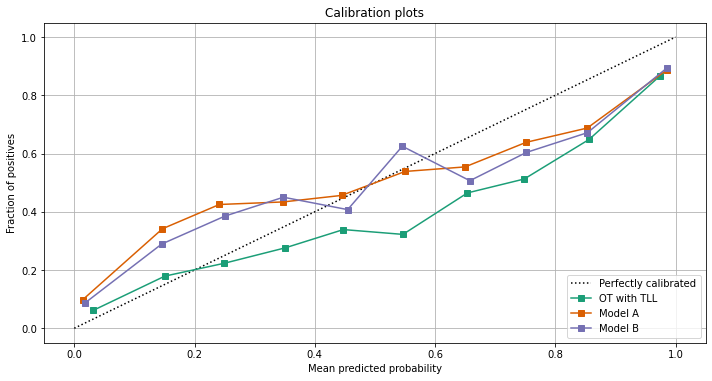

In [60]:
clf_list = [
    (fusedModel, "OT with TLL"),
    (modelA, "Model A"),
    (modelB, "Model B")
]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    display = plot_calibration_curve(
        clf,
        valid_iter,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")
# Add histogram
# grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
# for i, (_, name) in enumerate(clf_list):
#     row, col = grid_positions[i]
#     ax = fig.add_subplot(gs[row, col])
#     ax.hist(
#         calibration_displays[name].y_prob,
#         range=(0, 1),
#         bins=10,
#         label=name,
#         color=colors(i),
#     )
#     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")
plt.tight_layout()
plt.show()